In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import calendar

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the two tables from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)
df_predictions = pd.read_sql_query("SELECT * from Predictions", con)

# close the connection of the database
con.close()

# Exercise 1
Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.

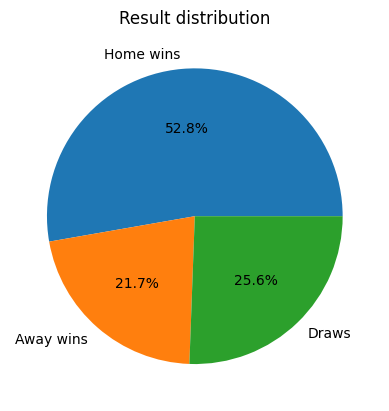

In [3]:
# creating two new columns, one for the score of the home team, and one for the score of the away team
df_matches[['home_score', 'away_score']] = df_matches['score'].str.split(':', expand=True).astype(float)

# creating one new column to show which team one, or if it was a tie
df_matches['winner'] = df_matches.apply(lambda row: 
                                        np.nan if pd.isna(row['home_score']) or pd.isna(row['away_score'])
                                        else 1 if row['home_score'] > row['away_score']
                                        else 2 if row['home_score'] < row['away_score']
                                        else 'X', axis=1)

# getting the counts for the values 1, 2 and X in the winner column
result_counts = df_matches['winner'].value_counts()

# extracting the counts for each specific value, making it 0 if it does not exist
number_home_wins = result_counts.get(1, 0)
number_away_wins = result_counts.get(2, 0)
number_draws = result_counts.get('X', 0)

# getting the total number of games played by summing the counts for all the possible game results
total_plays = number_home_wins + number_away_wins + number_draws

# defining the value array for the pie plot
y = np.array([number_home_wins, number_away_wins, number_draws])
# defining the lables for the pie plot
labels = ['Home wins', 'Away wins', 'Draws']

# initiating and plotting the pie plot including the percentages of the three options
plt.pie(y, labels = labels, autopct = "%1.1f%%")
plt.title('Result distribution')
plt.show()

# Exercise 2
What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say biggest we mean those with the highest goal difference. Show the top ten of them in a table.

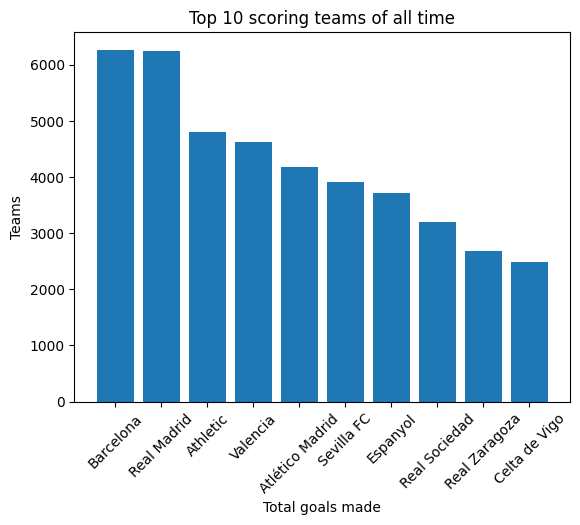

In [4]:
# create two subsets of the df_matches dataframe filtering on division 1 and aggregating the total made goals for the teams when playing at home and when playing away
df_home_goals = df_matches[df_matches['division'] == 1].groupby('home_team')['home_score'].sum()
df_away_goals = df_matches[df_matches['division'] == 1].groupby('away_team')['away_score'].sum()

# combine the subsets into a new dataframe, also creating a total column with the total amount of goals a club has made
df_rank = pd.DataFrame({
    'home_goals': df_home_goals,
    'away_goals': df_away_goals,
    'total_goals': df_home_goals + df_away_goals
})

# get the top 10 clubs that made the most goals
top_10_goals = df_rank[['total_goals']].sort_values('total_goals', ascending=False).head(10)

# plot the top 10 teams and the amount of goals they scored
plt.bar(top_10_goals.index, top_10_goals['total_goals'])
plt.xlabel('Total goals made')
plt.ylabel('Teams')
plt.title('Top 10 scoring teams of all time')
plt.xticks(top_10_goals.index, top_10_goals.index, rotation=45)
plt.show()

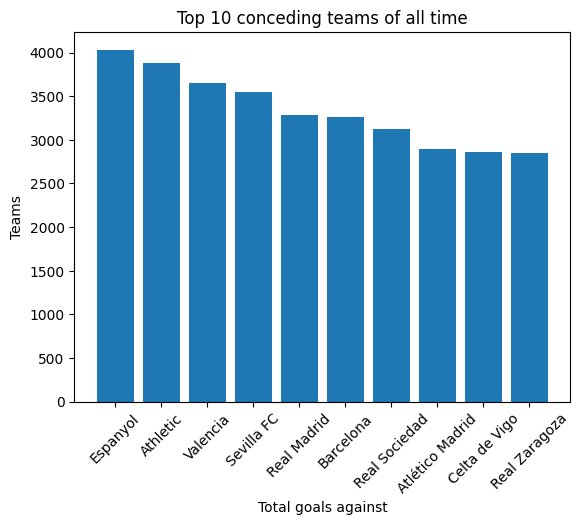

In [5]:
# create two subsets of the df_matches dataframe filtering on division 1 and aggregating the total made goals against every team when playing at home and when playing away
df_home_concedes = df_matches[df_matches['division'] == 1].groupby('home_team')['away_score'].sum()
df_away_concedes = df_matches[df_matches['division'] == 1].groupby('away_team')['home_score'].sum()

# combine the subsets into a new dataframe, also creating a total column with the total amount of goals a club has had against them
df_concede = pd.DataFrame({
    'home_concedes': df_home_concedes,
    'away_concedes': df_away_concedes,
    'total_concedes': df_home_concedes + df_away_concedes
})

# get the top 10 clubs that had the most goals against them
top_10_concede = df_concede[['total_concedes']].sort_values('total_concedes', ascending=False).head(10)

# plot the top 10 teams and the amount of goals they got against them
plt.bar(top_10_concede.index, top_10_concede['total_concedes'])
plt.xlabel('Total goals against')
plt.ylabel('Teams')
plt.title('Top 10 conceding teams of all time')
plt.xticks(top_10_concede.index, top_10_concede.index, rotation=45)
plt.show()

In [6]:
# creating a new column for the absolute difference between the score of the team playing at home and the visiting team
df_matches['difference'] = abs(df_matches['home_score'] - df_matches['away_score'])

# showing the table with the top 10 biggest wins
df_matches[['date', 'home_team', 'away_team', 'score', 'difference']].sort_values('difference', ascending = False).head(10)

,date,home_team,away_team,score,difference
25995,1/8/41,Real Sociedad,Real Valladolid,14:2,12.0
225,2/8/31,Athletic,Barcelona,12:1,11.0
27533,1/13/57,Real Gijón,Lérida,11:0,11.0
936,9/29/40,Sevilla FC,Barcelona,11:1,10.0
26884,9/4/49,CE Sabadell,SD Erandio Club,11:1,10.0
1071,9/28/41,Sevilla FC,Real Oviedo,10:0,10.0
28591,11/11/62,Real Sociedad,CE Sabadell,11:1,10.0
1168,1/11/42,Athletic,Celta de Vigo,10:0,10.0
2787,11/19/50,Athletic,Lérida,10:0,10.0
4428,10/20/57,Atlético Madrid,UD Las Palmas,9:0,9.0


# excercise 3
here has been a lot of discussion about how LaLiga’s television rights have changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.

In [7]:
# function change the 2 digit representation of the year in the "date" column to a 4 digit representation
def get_year(season, date):
    # get only the 2 digit year part of the date
    year = date.split("/")[-1]
    
    # split the years of the season into two separate years
    season_years = season.split("-")
    
    # check if the 2 digit year part of the date are equal to the last part of the start year or the end year of the season
    for season_year in season_years:
        # if the 2 digit part is equal to the last part of one of the season years
        if year == season_year[2:4]:
            # return the complete date, now containing a 4 digit year representation
            return f"{date.split("/")[0]}/{date.split("/")[1]}/{season_year}"

In [8]:
# improve the "date" column using the "get_year" function to change the year from 2 digits to the correct 4 digits
df_matches['date'] = df_matches.apply(lambda row: get_year(row['season'], row['date']), axis=1)

# change the "date" column to datetime
df_matches['date'] = pd.to_datetime(df_matches['date'], format='mixed')

# add a weekday column to store which day of the week the match was played
df_matches['weekday'] = df_matches.apply(lambda row: calendar.day_name[row['date'].weekday()], axis=1)

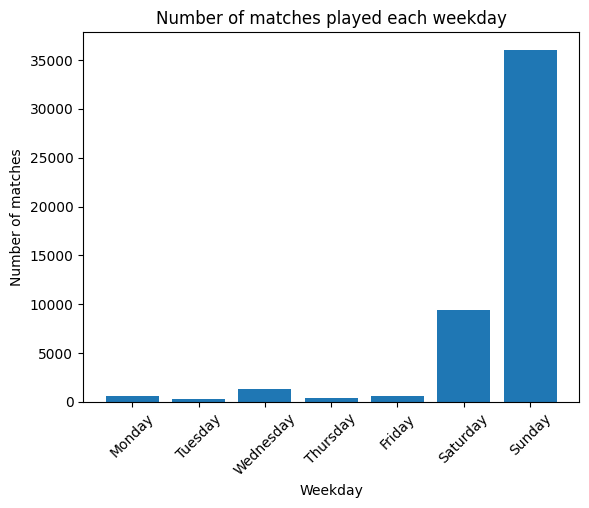

In [9]:
# create a crosstab to find the amount of matches for every season on every day
weekday_counts = pd.crosstab(df_matches['weekday'], df_matches['season'])

# reindex the crosstab so the days are in the right order and empty cells are filled with 0
weekday_counts = weekday_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

# add a total column for the total amount of matches for each day for all the seasons combined
weekday_counts['total'] = weekday_counts.sum(axis=1)

# plot the weekday names and their counts
plt.bar(weekday_counts.index, weekday_counts['total'])
plt.xlabel('Weekday')
plt.ylabel('Number of matches')
plt.title('Number of matches played each weekday')
plt.xticks(weekday_counts.index, weekday_counts.index, rotation=45)
plt.show()

In [10]:
# change the "time" column to datetime
df_matches['time'] = pd.to_datetime(df_matches['time'], format='%I:%M %p', errors='coerce').dt.time

# add an extra column with the time in hours from midnight (so 12:15 AM is 0.25 hours and 1 PM is 13.0 hours)
df_matches['time_in_hours'] = df_matches['time'].apply(lambda x: x.hour + x.minute / 60 if pd.notna(x) else None)

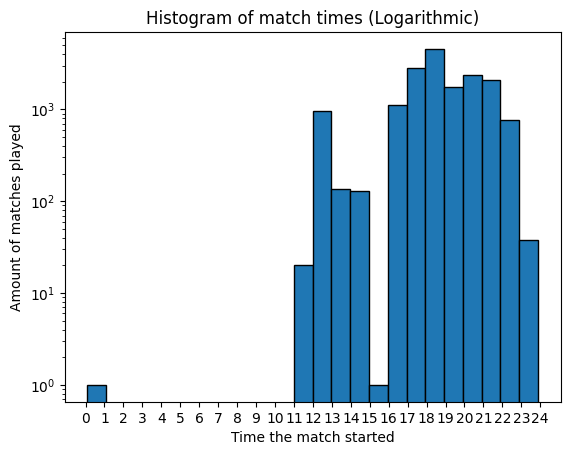

In [11]:
# plot the match times in a logarithmic scale to make sure that all the times (also the ones that are barely in the database) are visable
plt.hist(df_matches['time_in_hours'].dropna(), bins=24, edgecolor='black', log=True)
# set the xticks from 0 to 25 to represent the 24 hours in a day
plt.xticks(range(0, 25))

# Add labels and title
plt.xlabel('Time the match started')
plt.ylabel('Amount of matches played')
plt.title('Histogram of match times (Logarithmic)')
plt.show()

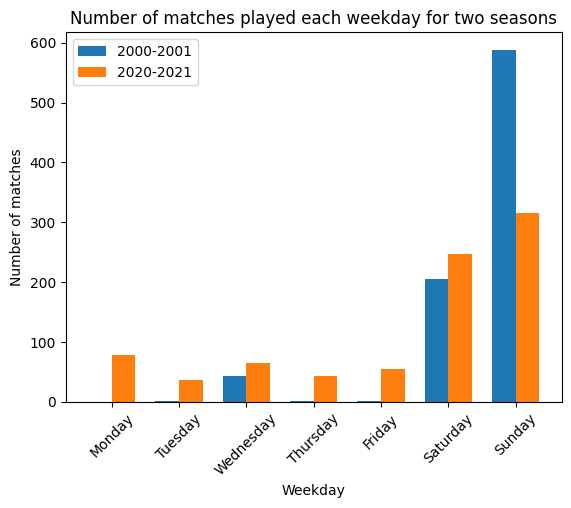

In [12]:
# use the same "weekday_counts" crosstab as before and get the counts for the seasons 2000-2001 and 2020-2021
counts_2000_2001 = weekday_counts['2000-2001']
counts_2020_2021 = weekday_counts['2020-2021']

# define the bar width and set the positions of the bars
bar_width = 0.35
index = np.arange(len(weekday_counts.index))

# create two bars, one for each season
plt.bar(index, counts_2000_2001, bar_width, label='2000-2001')
plt.bar(index + bar_width, counts_2020_2021, bar_width, label='2020-2021')

# plot the weekdays and their counts for the two seasons
plt.xlabel('Weekday')
plt.ylabel('Number of matches')
plt.title('Number of matches played each weekday for two seasons')
plt.xticks(index + bar_width / 2, weekday_counts.index, rotation=45)
plt.legend()
plt.show()

In [13]:
# counts_2000_2001 = df_matches[df_matches['season'] == '2000-2001'][['weekday']].value_counts()
# counts_2020_2021 = df_matches[df_matches['season'] == '2020-2021'][['weekday']].value_counts()
# 
# index_list_2000_2001 = counts_2000_2001.index.get_level_values(0).tolist()  # Get the index 
# value_list_2000_2001 = counts_2000_2001.values.tolist()  # Get the counts (values)
# weekday_names_2000_2001 = [calendar.day_name[i] for i in index_list_2000_2001]
# 
# index_list_2020_2021 = counts_2020_2021.index.get_level_values(0).tolist()  # Get the index 
# value_list_2020_2021 = counts_2020_2021.values.tolist()  # Get the counts (values)
# weekday_names_2020_2021 = [calendar.day_name[i] for i in index_list_2020_2021]
# 
# fig, ax = plt.subplots(figsize=(20,5))
# 
# ax.barh(weekday_names_2000_2001[::-1], value_list_2000_2001[::-1], alpha = 0.5, label='2000-2001')
# ax.barh(weekday_names_2020_2021[::-1], value_list_2020_2021[::-1], alpha = 0.5, label='2020-2021')
# plt.legend()
# 
# plt.show()

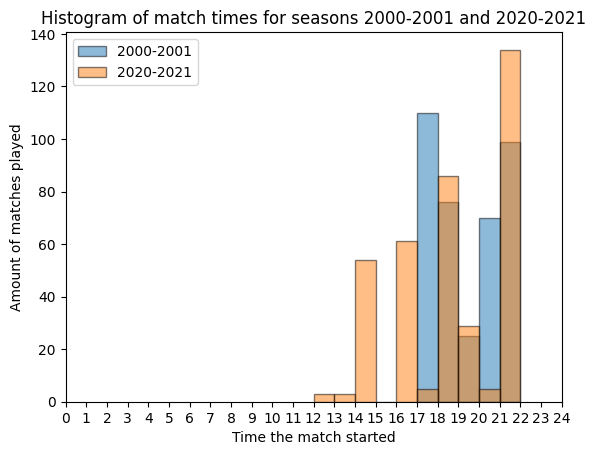

In [14]:
# create two histograms, one for each of the two seasons, filtered on division 
plt.hist(df_matches[(df_matches['season'] == '2000-2001') & (df_matches['division'] == 1)]['time_in_hours'], bins=5, alpha=0.5, edgecolor='black', label='2000-2001')
plt.hist(df_matches[(df_matches['season'] == '2020-2021') & (df_matches['division'] == 1)]['time_in_hours'], bins=10, alpha=0.5, edgecolor='black', label='2020-2021')

# set the xticks from 0 to 25 to represent the 24 hours in a day
plt.xticks(range(0, 25))

# Add labels and title
plt.xlabel('Time the match started')
plt.ylabel('Amount of matches played')
plt.title('Histogram of match times for seasons 2000-2001 and 2020-2021')
plt.legend()
plt.show()

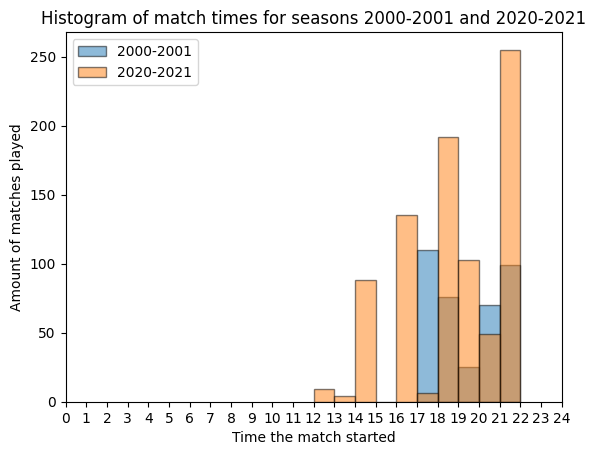

In [16]:
# create two histograms, one for each of the two seasons, NOT filtered on division 
plt.hist(df_matches[df_matches['season'] == '2000-2001']['time_in_hours'], bins=5, alpha=0.5, edgecolor='black', label='2000-2001')
plt.hist(df_matches[df_matches['season'] == '2020-2021']['time_in_hours'], bins=10, alpha=0.5, edgecolor='black', label='2020-2021')

# set the xticks from 0 to 25 to represent the 24 hours in a day
plt.xticks(range(0, 25))

# Add labels and title
plt.xlabel('Time the match started')
plt.ylabel('Amount of matches played')
plt.title('Histogram of match times for seasons 2000-2001 and 2020-2021')
plt.legend()
plt.show()

# Exercise 4